In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

data = pd.read_csv("Obama1516Clustered.csv")
data.drop("Unnamed: 0",inplace=True,axis=1)

vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores
data.drop(["text","modded_text","modded1"],axis=1,inplace=True)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


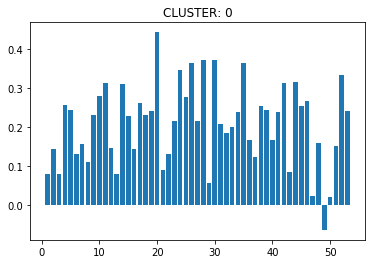

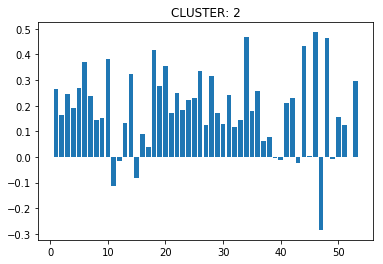

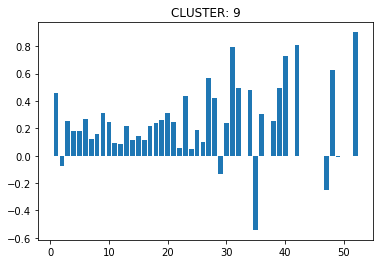

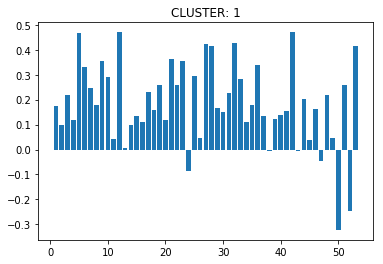

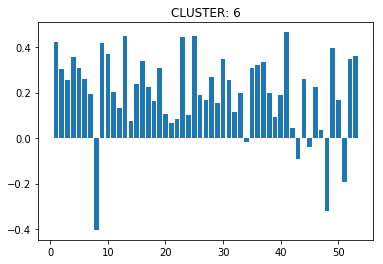

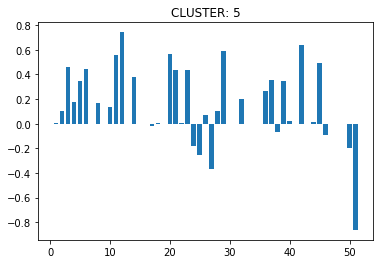

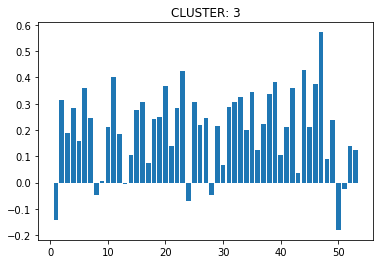

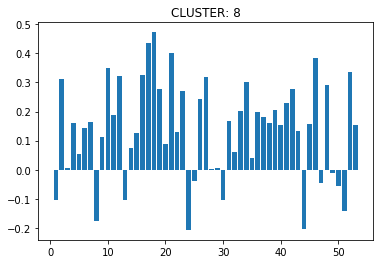

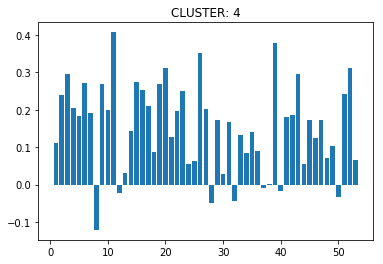

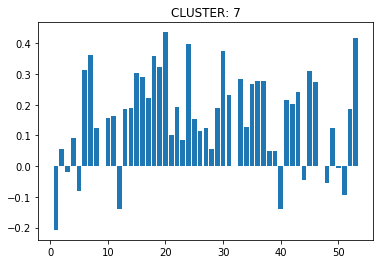

In [2]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()

In [3]:
x1 = data[data["labels"] == 2]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
   
stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]

x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(str(x) for x in x.split() if str(x) in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

633


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


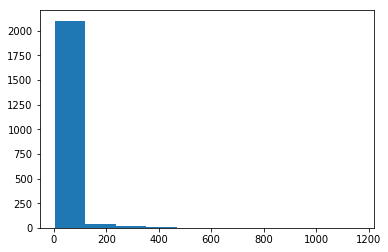

Index(['date_year', 'week_year', 'vaderScore', '10', '10000', '100000',
       '100th', '11', '1110am', '12',
       ...
       'yesterday', 'york', 'yosemit', 'youll', 'young', 'your',
       'youtubeasksobama', 'youv', 'zero', 'zika'],
      dtype='object', length=1446)

In [4]:
plt.hist(stemmed_words)
plt.show()

x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!! sembra che il tempo peggiori sse e migliori silhouette
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels",],axis=1) 
#dataWithText = res
res1.columns

In [5]:
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels",],axis=1) 

sil = []
for c in range(10,22):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

10 0.6123701318246276
11 0.5824197277127364
12 0.5617348805103654
13 0.572248659033293
14 0.5584727917503147
15 0.5556536543247742
16 0.5325490231077677
17 0.5217908588896113
18 0.521766900729865
19 0.5123373732381968
20 0.48910445251584517
21 0.4898078948433919


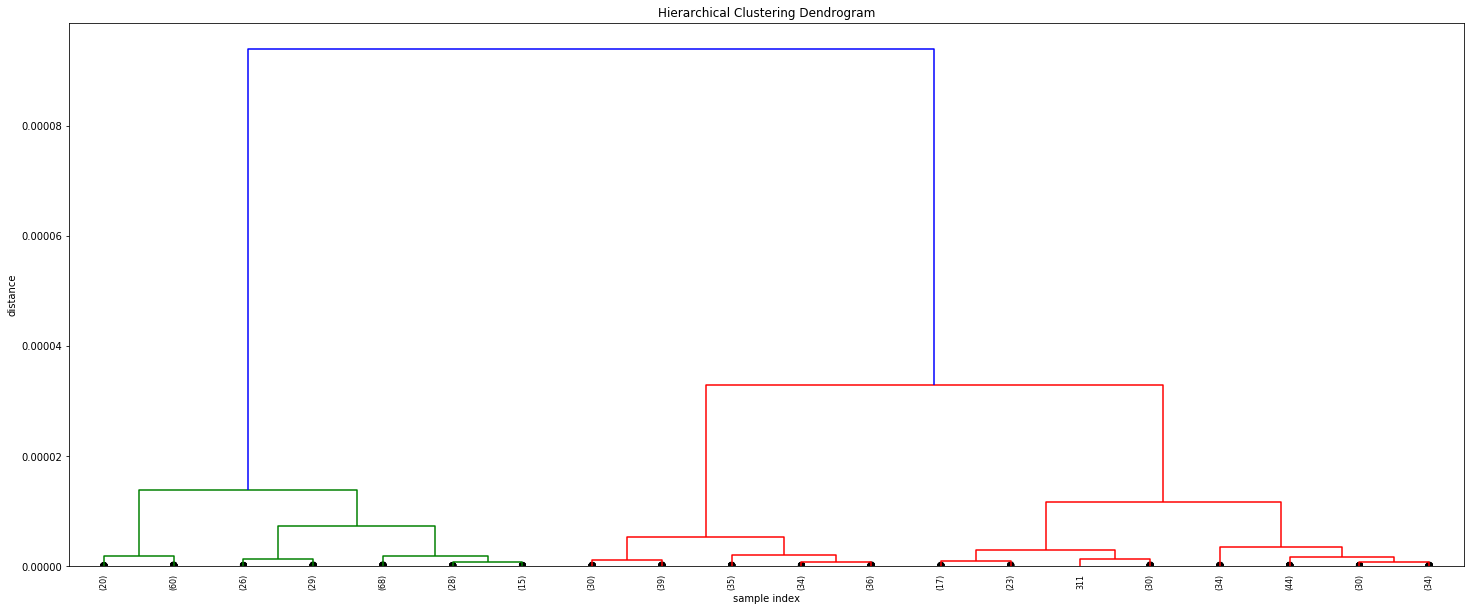

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(res1, 'average', "cosine")
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()


In [7]:
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels",],axis=1) 
print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=15)
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)

Index(['date_year', 'week_year', 'vaderScore', '10', '10000', '100000',
       '100th', '11', '1110am', '12',
       ...
       'yesterday', 'york', 'yosemit', 'youll', 'young', 'your',
       'youtubeasksobama', 'youv', 'zero', 'zika'],
      dtype='object', length=1446)
0.5556536543247742


In [8]:
res1["labels"] = labels
dataWithText["labels"] = labels
g = res1.drop(["vaderScore"],axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  8  lunghezza  60
NUMBER OF TOPICS FOR CLUSTER  8  :  4
2016    34
2015    26
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[1, 2, 3, 4]
numero di settimane in cluster 4


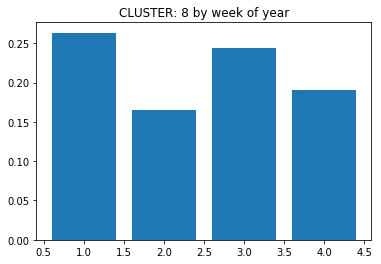

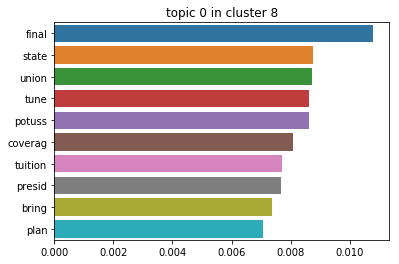

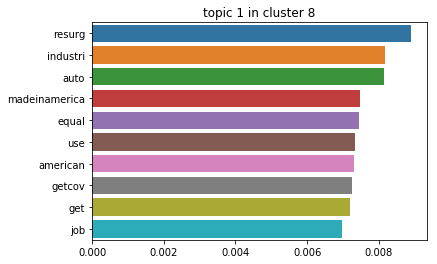

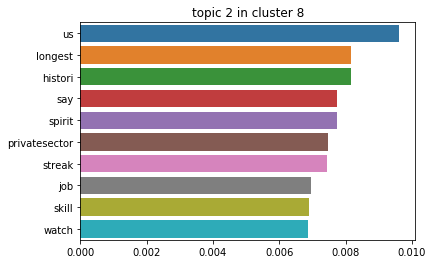

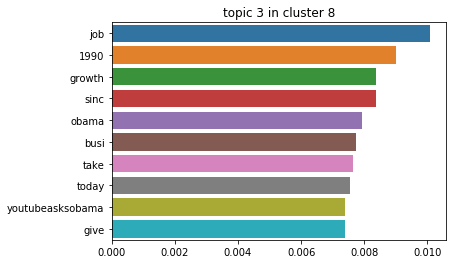

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


topics_count [17, 16, 16, 11]


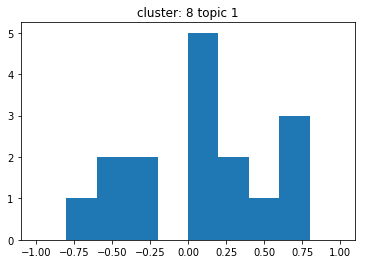

topic 1 [2015, 2016]


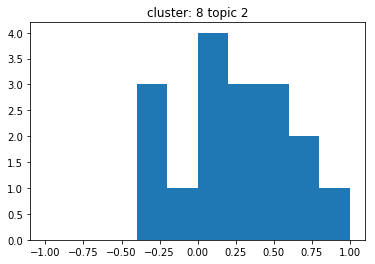

topic 2 [2015, 2016]


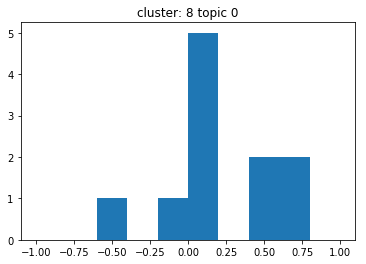

topic 0 [2015, 2016]


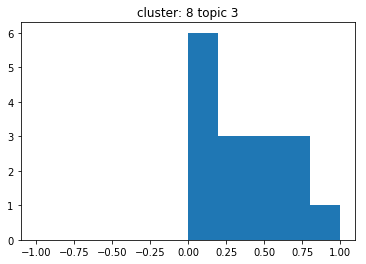

topic 3 [2015, 2016]
cluster  11  lunghezza  20
NUMBER OF TOPICS FOR CLUSTER  11  :  1
2016    12
2015     8
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[5, 6]
numero di settimane in cluster 2


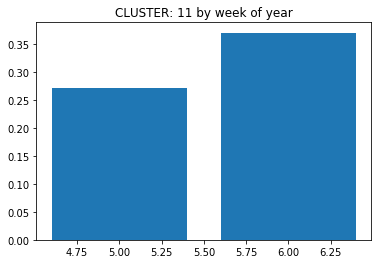

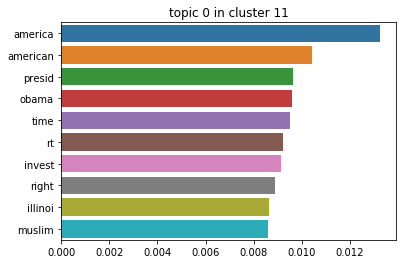

topics_count [20]


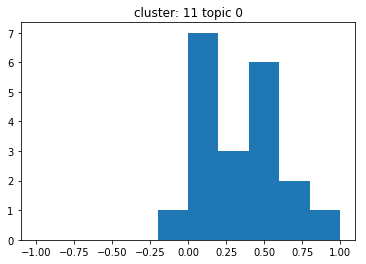

topic 0 [2015, 2016]
cluster  10  lunghezza  68
NUMBER OF TOPICS FOR CLUSTER  10  :  1
2016    38
2015    30
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[7, 8, 9, 10]
numero di settimane in cluster 4


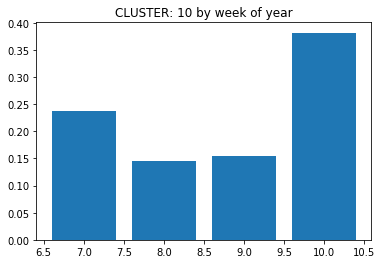

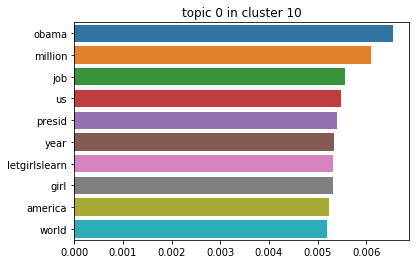

topics_count [68]


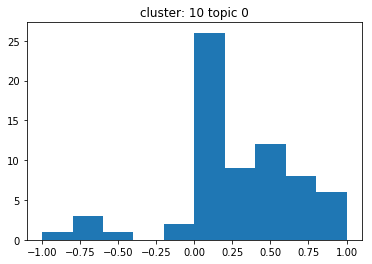

topic 0 [2015, 2016]
cluster  4  lunghezza  43
NUMBER OF TOPICS FOR CLUSTER  4  :  2
2016    23
2015    20
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[11, 12, 13, 14]
numero di settimane in cluster 4


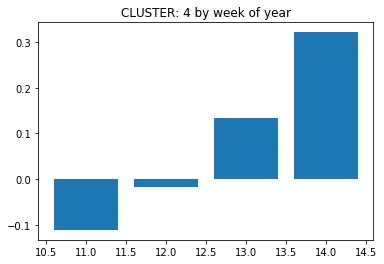

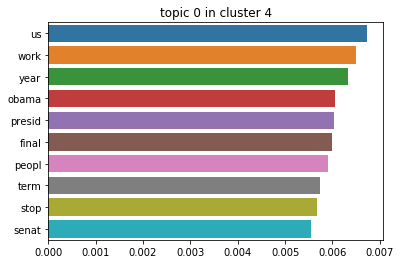

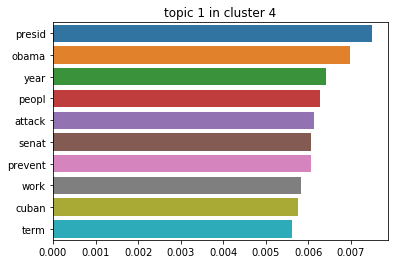

topics_count [24, 19]


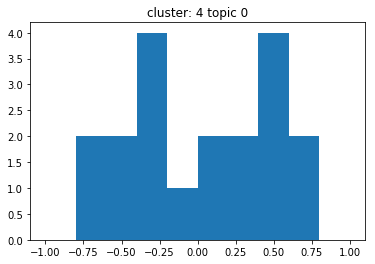

topic 0 [2015, 2016]


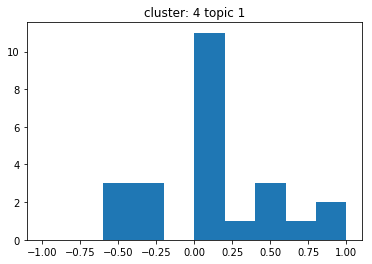

topic 1 [2015, 2016]
cluster  14  lunghezza  26
NUMBER OF TOPICS FOR CLUSTER  14  :  2
2016    20
2015     6
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[15, 16, 17]
numero di settimane in cluster 3


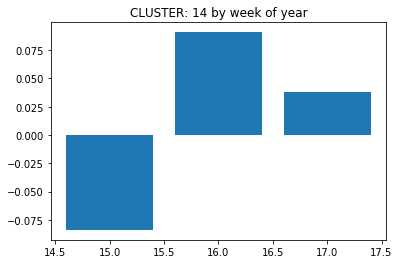

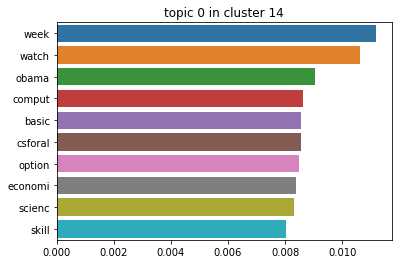

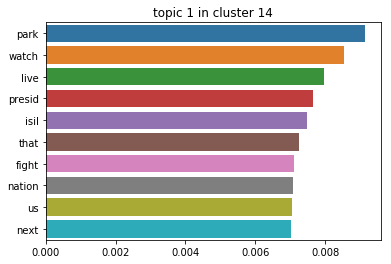

topics_count [13, 13]


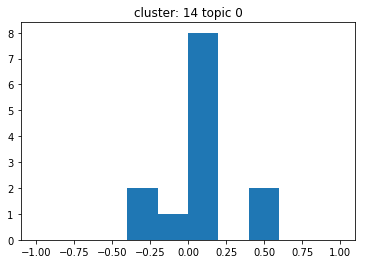

topic 0 [2015, 2016]


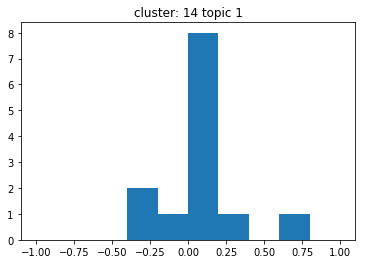

topic 1 [2015, 2016]
cluster  12  lunghezza  29
NUMBER OF TOPICS FOR CLUSTER  12  :  2
2016    21
2015     8
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[18, 19, 20]
numero di settimane in cluster 3


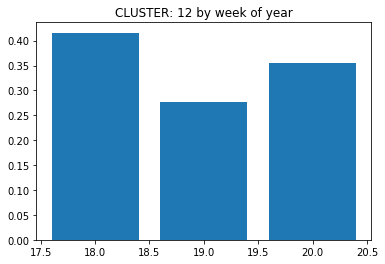

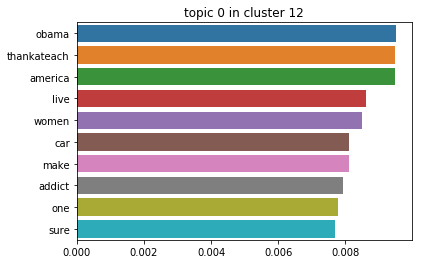

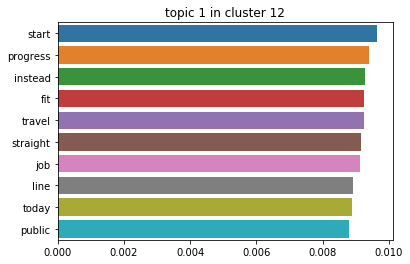

topics_count [15, 14]


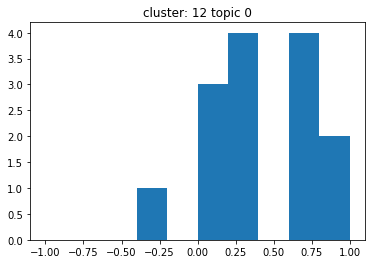

topic 0 [2015, 2016]


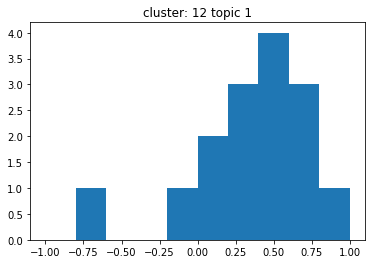

topic 1 [2015, 2016]
cluster  9  lunghezza  35
NUMBER OF TOPICS FOR CLUSTER  9  :  1
2016    20
2015    15
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[21, 22, 23]
numero di settimane in cluster 3


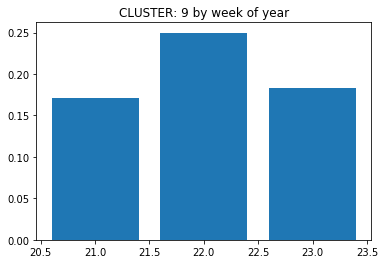

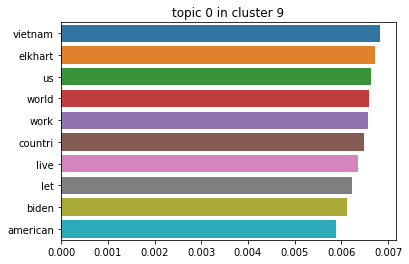

topics_count [35]


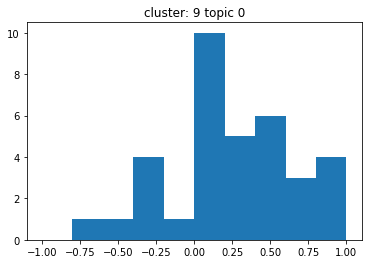

topic 0 [2015, 2016]
cluster  2  lunghezza  70
NUMBER OF TOPICS FOR CLUSTER  2  :  1
2015    37
2016    33
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[24, 25, 26, 27]
numero di settimane in cluster 4


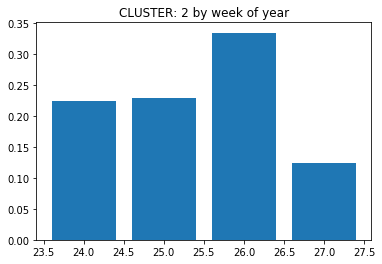

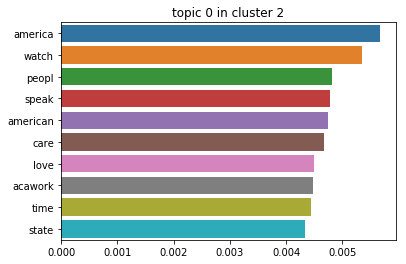

topics_count [70]


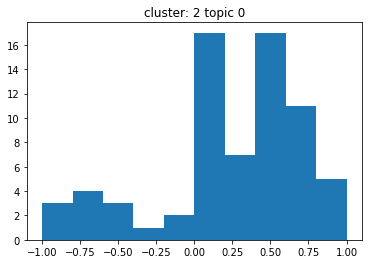

topic 0 [2015, 2016]
cluster  0  lunghezza  69
NUMBER OF TOPICS FOR CLUSTER  0  :  1
2016    39
2015    30
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[28, 29, 30, 31, 32, 33]
numero di settimane in cluster 6


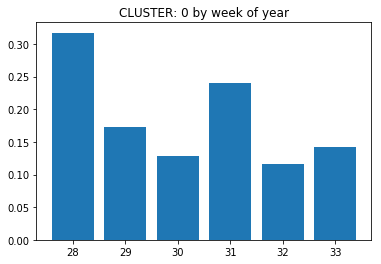

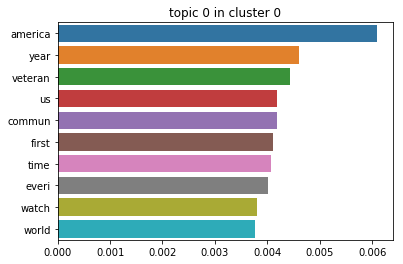

topics_count [69]


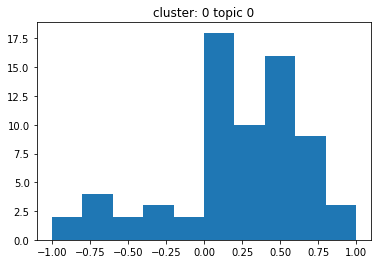

topic 0 [2015, 2016]
cluster  7  lunghezza  34
NUMBER OF TOPICS FOR CLUSTER  7  :  2
2016    18
2015    16
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[34, 35, 36]
numero di settimane in cluster 3


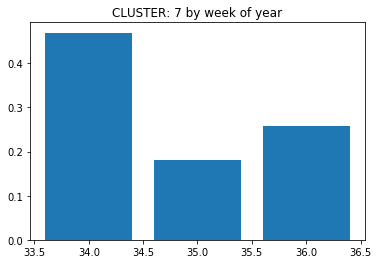

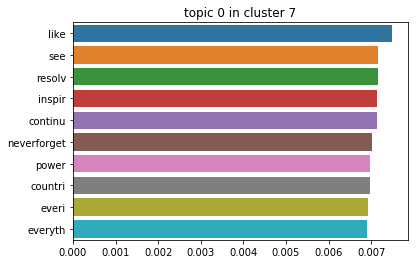

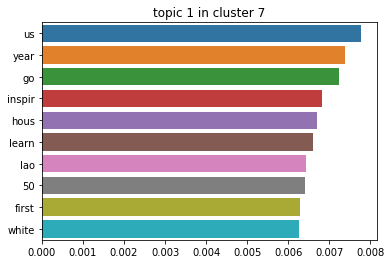

topics_count [18, 16]


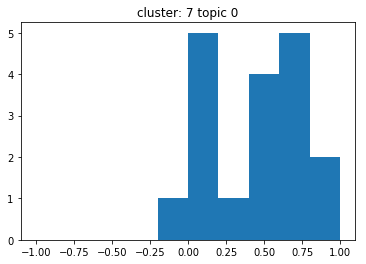

topic 0 [2015, 2016]


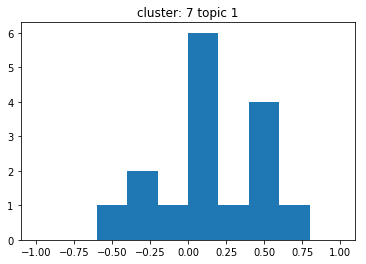

topic 1 [2015, 2016]
cluster  3  lunghezza  64
NUMBER OF TOPICS FOR CLUSTER  3  :  1
2015    37
2016    27
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[37, 38, 39, 40]
numero di settimane in cluster 4


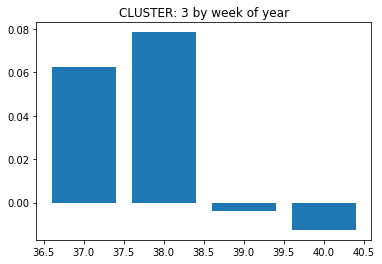

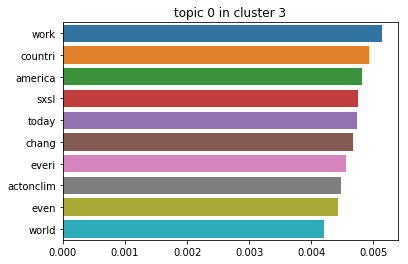

topics_count [64]


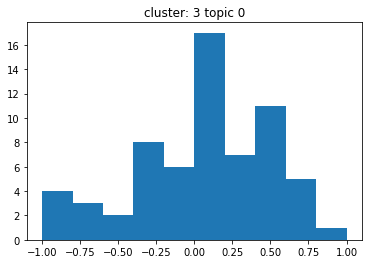

topic 0 [2015, 2016]
cluster  5  lunghezza  44
NUMBER OF TOPICS FOR CLUSTER  5  :  1
2016    24
2015    20
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[41, 42, 43]
numero di settimane in cluster 3


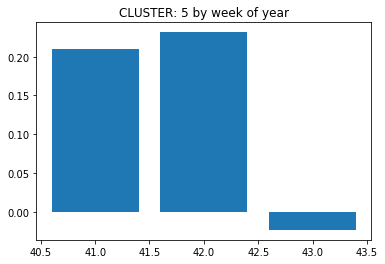

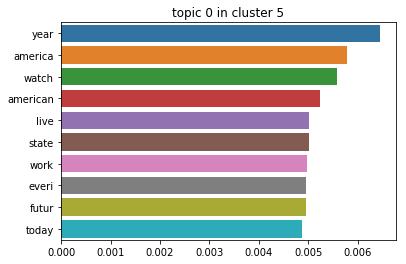

topics_count [44]


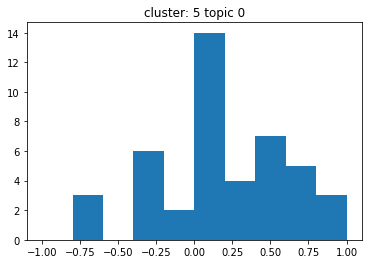

topic 0 [2015, 2016]
cluster  1  lunghezza  40
NUMBER OF TOPICS FOR CLUSTER  1  :  2
2015    28
2016    12
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[44, 45, 46, 47, 48]
numero di settimane in cluster 5


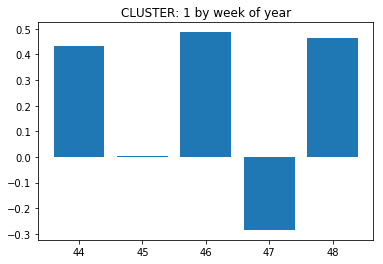

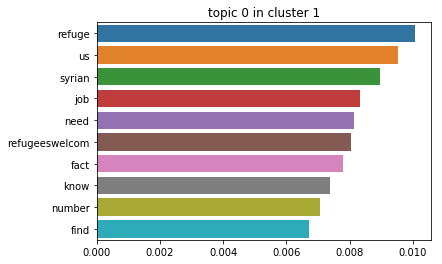

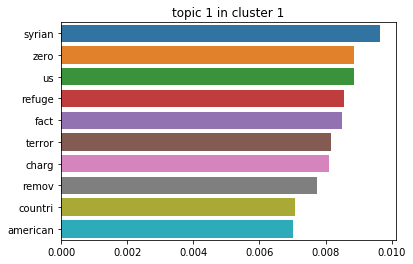

topics_count [21, 19]


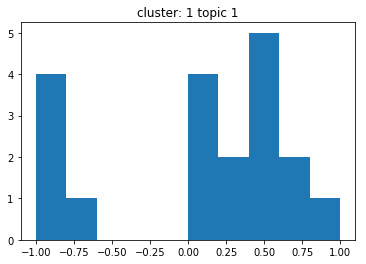

topic 1 [2015, 2016]


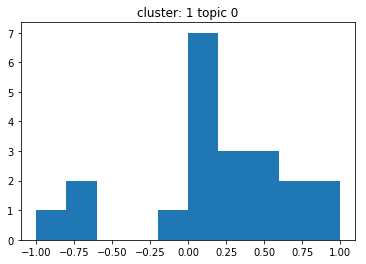

topic 0 [2015, 2016]
cluster  6  lunghezza  30
NUMBER OF TOPICS FOR CLUSTER  6  :  1
2015    30
Name: date_year, dtype: int64
[2015]
anni nel cluster  1
[49, 50, 51]
numero di settimane in cluster 3


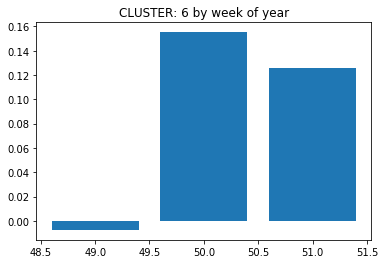

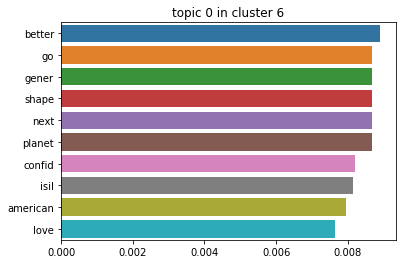

topics_count [30]


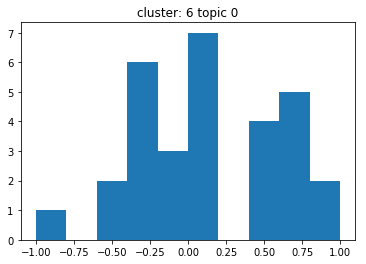

topic 0 [2015]


In [10]:
for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))
        
        from gensim.corpora.dictionary import Dictionary

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        
        common_dictionary = Dictionary(corp)
        common_corpus = [common_dictionary.doc2bow(text) for text in corp]
        tfidf = TfidfModel(common_corpus)
        tfidf_corpus = tfidf[common_corpus]


        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)

        lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary)

        
        #plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        #plt.title("Sentiment score for cluster: " + str(cluster))
        #plt.show()
        print(d1["date_year"].value_counts())
        print(d1["date_year"].unique().tolist())
        print("anni nel cluster ", len(d1["date_year"].unique().tolist()))
        print(d1["week_year"].unique().tolist())
        print("numero di settimane in cluster", len(d1["week_year"].unique().tolist()))
        
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster) + " by week of year")
        plt.bar(time.index, time )
        plt.show()

        topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False,log=True)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.001:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            sns.barplot(x=weights, y=words)
            plt.show()        
        topicColumn = []
        topicList = {}
        for el in tfidf_corpus:
            vector = lda.get_document_topics(el)
            #get topic
            m = max(y for (x,y) in vector)
            ind = [x for x, y in enumerate(vector) if y[1] == m][0]
            #print(ind,m)
            if ind not in topicList:
                topicList[ind] = 1
            else: 
                topicList[ind] += 1
            topicColumn.append(ind)
        d1["topic"] = topicColumn
        #print(topicColumn)
        print("topics_count",d1["topic"].value_counts().tolist())
        
        for t in d1["topic"].unique():
            d2 = d1[d1["topic"] == t]
            plt.title("cluster: " + str(cluster) + " topic " + str(t))
            plt.hist(d2["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
            plt.show()
            print("topic "+ str(t), d2["date_year"].unique().tolist())
        